## Introduction and transition from the slides

### Exercise 1 
Try different configurations for packing the knapsack/choosing the customer orders. Try to maximize the total value while not violating the constraint.
(possibly insert knapsack game here?!)

# Knapsack Problem

## rewrite this section to make transition from slides
Consider the following problem: You are a thief on a run, and you have to flee your home as fast as you can. The only way to carry your stolen goods is via a backpack limited to carrying 15 kg. You have stolen 5 items over the days, each with a specific weight and a specific value. You can't pack all of them, and of course want to carry as much total value in your backpack as possible. Thus, you have to make a choice: Which items do you pack into your backpack?

Generalizing, you are faced with the following optimization problem:

You have a finite set of items $U$, a weight-function $w: U\rightarrow \mathbb{R}$ and a value-function $v: U\rightarrow \mathbb{R}$. Further, you have a weight limit of $C\in\mathbb{R}$.
You are now searching for the subset $K\subseteq U$ with:

max $\sum_{u\in K}v(u)$

st. $\sum_{u\in K}w(u)\leq C$.

Reformulated as QUBO (quadratic constraint binary optimization) problem for supply chain (only supply, hence weights and values must be positive) you get ($i\in\{0,1,...,n\}$, item $x_i\in\{0,1\}$, weight $w_i\in\mathbb{R}_+$, value $v_i\in\mathbb{R}_+$, capacity $C\in\mathbb{R}_+$):

max $\sum_{i=1}^n v_ix_i$

st. $\sum_{u\in K}w_ix_i\leq C$

$x\in\{0,1\}^n$.

# Quantum Knapsack

#### Motivation:
A good starting point for a useful quantum application is to identify problems that boil down to classical complexity classes that are known to be hard to solve. Given that the exact complexity class of quantum computers is yet unclear, but larger than of classical computers, it seems promising to tackle such classical hard problems. The knapsack or traveling salesman problem are such examples. They are NP-complete and very hard to find good approximate solutions for. In order to use a possible quantum advantage, the encoding of the problem in a quantum mechanical and useful way is key. One approach taken in many optimisation problems is, to encode the solution of a problem into the lowest energystate of a quantum mechanical system. The quantum mechanical system of choice will be a spin-system (qubit-system) known as Ising Model.

#### Encoding the Knapsack problem
One approach is to encode the knapsack problem into a QUBO, which we can then map to an Ising Model that has as minimal energy the optimal solution of the knapsack problem.

As first step we should encode our main objective to maximize the value of items packed into the lowest energy state of our QUBO. As mentioned before, the bitstring $x\in\{0,1\}^n$ describes us either packing an item (1) or not (0) (e.g. only the first item is packed results in $v_1x_1=v_1$). We therefor end up with 
$$E=-\sum_i v_i x_i,$$ 
to encode the maximization.

Next, we want to add the constraint of staying within the total capacity $C$ of our knapsack. As a first approach, one might think of encoding the constraint $\sum_i w_ix_i\leq C$ as a penalty term:

$$E_{\text{penalty}}=A(\sum_i w_ix_i -C)^2.$$

The problem with this encoding is, that we penalize packing more than $C$ just as packing less than $C$. This is a problem, since there are many configurations in which the optimal configuration does not exactly fill the backpack. We are thus wrongly penalizing and are limiting our problem by using this simplification. To resolve this, we can introduce a helper variable $y_n$ for $1\leq n\leq C$. Its role is to be $1$ if the total capacity of the items in the knapsack is $n$, and $0$ otherwise. As a result, the sum of all the capacities for the items selected must equal the total capacity of the items (every binary variable $y_n$ is 0, except for the one corresponding to the total capacity):

$$\sum_i w_ix_i=\sum_n ny_n.$$

The adjusted penalty term is thus:

$$E_{penalty_1} = A (\sum_i w_i x_i -\sum_n n y_n)^2.$$

Now we only add a penalty if the relation is not satisfied, but do not add anything if it is (having reached the optimal configuration with the corresponding total capacity). Since $y_n$ is $1$ if the total capacity of the items in the knapsack is $n$ and $0$ otherwise, as the last part we have to include the constraint $\sum_n y_n =1$. Similar to before, we can simply encode this via
$$E_{penalty_2} = A(1-\sum_n y_n)^2.$$

Combining all three terms, we have found a possible energy-encoding of the knapsack problem:

$$E = A(1-\sum_n y_n)^2+A(\sum_i w_ix_i-\sum_n ny_n)^2-\sum_i c_ix_i.$$

If we have $N$ items and a maximal total capacity of $C$, the needed number of qubits simply scale linear with:

$$\#\text{number of qubits} = N + ⌈C⌉.$$

As a last step we can map this QUBO formulation to an Ising-Model using the simple trick of
$$
Z_i\vert x \rangle = (-1)^{x_i}  \vert x \rangle = \left( 1-2x_i \right) \vert x \rangle \implies x_i \vert x \rangle = \frac{\mathbb{I}-Z_i}{2}\vert x \rangle,
$$
where $\mathbb{I}$ denotes the unit operator and $Z_i$ the Pauli-Z matrix for qubit $i$. We can thus rewrite our found QUBO formulation as a sum of Pauli-Z operators. As we will see, we can use Qiskits Quadratic Program class to do this for us.



### Test exercise (after the course)

Go to the TSP notebook and try to come up with a QUBO formulation yourself.

### Exercise 2
How would you choose the weighting factor $A$ for the penalty term? Choose from

1. $A=1$
2. $A=7$
3. $A=100$

and explain your choice.

## Generate QUBO and Hamiltonian

Multiply out goal function.
Compare with built-in Knapsack method?!

## Variational quantum algorithms

Since we have encoded our optimization task into a Hamiltonian, i.e. into physical data, we go to the algorithmic phase. We will implement our QUBO formulation with two different variational quantum algorithms. First, let's import the necessary Qiskit classes, and set up an optimizer and simulator to use.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from qiskit import IBMQ

from qiskit.algorithms import QAOA, VQE
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA
from qiskit import Aer

#Simulator
backend = Aer.get_backend('statevector_simulator')
#Optimizer
optimizer = COBYLA(maxiter=1000, tol=0.0001)

#load the qubo
qp = QuadraticProgram()
qp.read_from_lp_file('test_knapsack.lp')

### TODO:
Explanation about variational algorithms

We want to find the lowest energy state $\ket{\psi^*}$ of a quantum system. The variational method has two steps:
- Choose an ansatz or trial state parametrized by $\theta$: $\ket{\psi(\theta)}$
- Vary parameters $\theta$ to minimize the energy value $E(\theta)=\bra{\psi(\theta)}H\ket{\psi(\theta)}$ and find: $\theta^* = \text{arg}\min_{\theta}E(\theta)$

In general we will have multiple parameters to optimize over. We can use a variational quantum eigensolver to optimize these parameters $\theta_i$ after each execution of the circuit and the measurement 
$$E_p(\theta_1,...,\theta_i)=\bra{\theta_1,...,\theta_i} H\ket{\theta_1,...,\theta_i}.$$


One of such variational algorithms is VQE. 

## VQE

... go more into detail and explain VQE ... 

We can implement and run our QUBO with the Qiskit VQE class.

In [3]:
#VQE
form=EfficientSU2(num_qubits=9,su2_gates=['rx', 'z'], entanglement='full', reps=1)
vqe_mes=VQE(form,optimizer = optimizer, quantum_instance = backend)

# construct Minimum Eigen Optimizer based on QAOA
vqe = MinimumEigenOptimizer(vqe_mes)

# solve Quadratic Program
result = vqe.solve(qp)
print(result)

optimal function value: -11.0
optimal value: [1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS


/Users/matthiasw/opt/anaconda3/envs/qiskit_cur/lib/python3.9/site-packages/qiskit_optimization/algorithms/optimization_algorithm.py:141: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


## QAOA
QAOA (Quantum Approximate Optimization Algorithms) is a circuit inspired by the adiabatic theorem: If the Hamiltonian of a quantum system in its ground state is perturbed slowly enough, the system remains in its ground state.

If we have found an encoding of our problem in a Hamiltonian ($H_C$) whose ground state has the problem solution we can thus prepare the quantum system in the ground state of a simple Hamiltonian ($H_M$) and adiabatically evolve the simple Hamiltonian to the problem Hamiltonian (runtime $T$): $$H(t)=\frac{t}{T}H_C+(1-\frac{t}{T})H_M.$$
The evolution will be made up of two different layers with repetition $p$, which in the limit recover the adiabatic theorem: $$e^{-iH(t)\Delta t}=e^{-i(\frac{t}{T}H_C+(1-\frac{t}{T})H_M)\Delta t}=\lim_{p\to\infty}\Big(e^{-i\gamma H_C}e^{-i\beta H_M}\Big)^p,$$ 
with $\gamma = (1-\frac{t}{T})\Delta t$, $\beta = \frac{t}{T}\Delta t$, and $p\Delta t=T$. For $p$ layers we end up with $2p$ parameters we have to optimize over in each execution step.

Given the noise on current NISQ-devices we will be limited to some number of noisy gates we can apply before all the noise builds up to an amount that the entire QAOA fails. As a result there is a traid off between repetitions $p$ chosen and number of gates we can perform.

We can implement and run our QUBO with the Qiskit QAOA class.


In [4]:
# construct QAOA and the Minimum Eigen Optimizer
qaoa_mes = QAOA(reps=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve
result = qaoa.solve(qp)
print(result)

optimal function value: -11.0
optimal value: [1. 0. 1. 1. 0. 0. 0. 0. 1.]
status: SUCCESS


As mentioned, on NISQ-devices qubits and gates are subject to noise. This deeply effects the performance of an quantum algorithm. With the help of Qiskit we can set up a simple noise model and observe how our computational states get randomized.

In [5]:
#Create a basic noise model
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error

def get_noise(p_meas, p_reset,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_reset = pauli_error([('X',p_reset), ('I', 1 - p_reset)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_reset, "reset") # reset error 
    noise_model.add_all_qubit_quantum_error(error_gate1, ['h', 'id', 'rz', 'sx', 'x']) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

Job Status: job has successfully run


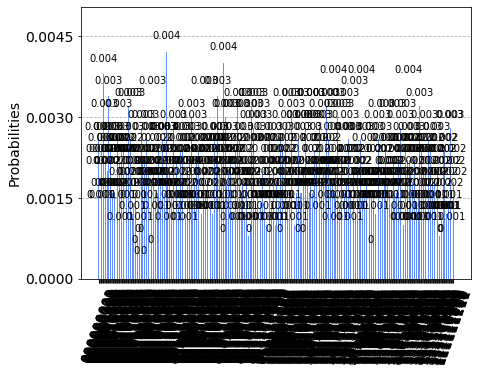

In [6]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.tools.monitor import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
from qiskit.visualization import plot_histogram

op, offset = qp.to_ising()

ansatz = QAOAAnsatz(op, reps = 1)  
qc = ansatz.bind_parameters([0.123, 0.432])
qc.measure_all()
qc_trans = transpile(qc,backend)
p = 0.1
job = backend.run(qc_trans, noise_model=get_noise(p,p,p), shots = 5000)
job_monitor(job)
    
counts = job.result().get_counts(qc_trans)
plot_histogram(counts)

Rough Outline:


As we can see, noise can ... However, for systematic errors you can apply error mitigation techniques (mitiq)...


Besides Noise a basic obstacle with arbitrary QUBO formulations is the structure of the energylandscape. Many energylandscapes challenge classical optimizers with local minima in which to get stuck in. ... add energygap, for slow enough evolution... 
As an example, let's have a look at the energylandscape of our formulated QUBO. Due to laptop performance, we can only look have a low resolution precomputed landscape. Nevertheless, it illustrates the ...

In [7]:
#import precomputed energylandscape of QUBO to interact with
import json
data_points = json.load(open("energylandscape_data.txt"))

import pandas as pd
import plotly.graph_objects as go

#create and display surface plot from data_points
df = pd.DataFrame(data_points)
df = df.pivot(index='beta', columns='gamma', values='energy')
matrix = df.to_numpy()
beta_values = df.index.tolist()
gamma_values = df.columns.tolist()

surface_plot = go.Surface(x=gamma_values, y=beta_values,z=matrix, colorscale ='Blues')
fig = go.Figure(data = surface_plot)
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title_text='Energylandscape', scene = dict(
                    xaxis_title='Parameter: gamma',
                    yaxis_title='Parameter: beta',
                    zaxis_title='Energy'),
                    )
fig.show()

### Todo
add plots here and after QAOA  (if there is more you guys want to add to the previous shown ones)


## Outlook (on variational algorithms)

- Warm-start QAOA & other variants
- Error mitigation
- QITE
- Move towards problem-specific algorithms and even hardware